In [3]:
# Auto-reload modules to reflect changes in imported files
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time

# Get the absolute path of src/ directory
notebooks_path = os.path.abspath(os.getcwd())  # Get the notebook’s current directory
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))

# Ensure src is in sys.path
if src_path not in sys.path:
    sys.path.insert(0, src_path)  # Insert at the beginning to prioritize it

# Import necessary modules from src
from Measure_sampling.Gen_Path_and_AdaptedTrees import *
from trees.Tree_Node import *
from trees.TreeAnalysis import *
from trees.TreeVisualization import *
from trees.Save_Load_trees import *
from trees.Tree_AWD_utilities import *

from benchmark_value_gaussian.Comp_AWD2_Gaussian import build_mean_and_cov, adapted_wasserstein_squared
from awd_trees.Gurobi_AOT import *
from awd_trees.Nested_Dist_Algo import compute_nested_distance

from Conditional_density.CD_nonparam import *

from AOT_numerics.mainfunctions import *
from AOT_numerics.measure import *
from AOT_numerics.normal_ot import *
from AOT_numerics.FVI_bench import *

from Measure_sampling.Extract_Sample_path_AOT import extract_sample_paths

from adapted_empirical_measure.AEM_kMeans import (
    empirical_k_means_measure,
    empirical_k_means_measure_new,
    empirical_k_means_measure_grid,
)
from adapted_empirical_measure.AEM_grid import empirical_grid_measure

# Suppress sklearn warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

ModuleNotFoundError: No module named 'Measure_sampling'

In [ ]:
import numpy as np

# Initialize samples
dim = 3
n_sample = 1000
normalize = False

L0 = np.array([[1, 0, 0], [1, 2, 0], [1, 2, 3]])
A0 = L0 @ L0.T  # A = LL^T
L = L0 / np.sqrt(np.trace(A0)) if normalize else L0
A = L @ L.T

M0 = np.array([[1, 0, 0], [2, 1, 0], [3, 2, 1]])
B0 = M0 @ M0.T  # B = MM^T
M = M0 / np.sqrt(np.trace(B0)) if normalize else M0
B = M @ M.T

Theoretical AW_2^2:  10.0


# Initialize samples
dim = 2
n_sample = 10000
normalize = False

L0 = np.array([[1, 0], [1, 2]])
A0 = L0 @ L0.T  # A = LL^T
L = L0 / np.sqrt(np.trace(A0)) if normalize else L0
A = L @ L.T
# np.linalg.cholesky(A) -  L

M0 = np.array([[1, 0], [2, 1]])
B0 = M0 @ M0.T  # A = LL^T
M = M0 / np.sqrt(np.trace(B0)) if normalize else M0
B = M @ M.T

L:
[[1 0 0]
 [1 2 0]
 [1 2 3]]
A = LL^T:
[[ 1  1  1]
 [ 1  5  5]
 [ 1  5 14]]
M:
[[1 0 0]
 [2 1 0]
 [3 2 1]]
B = MM^T:
[[ 1  2  3]
 [ 2  5  8]
 [ 3  8 14]]


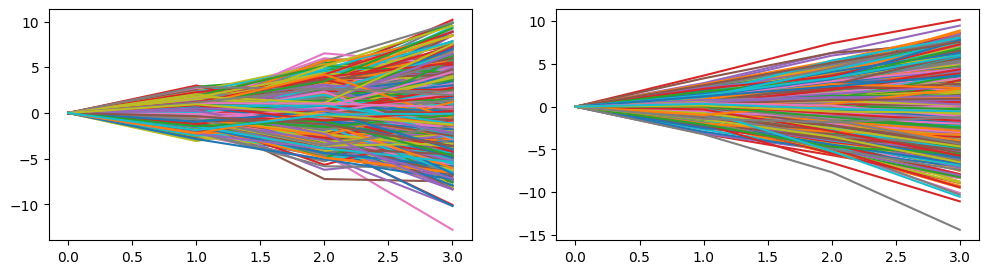

In [45]:
# np.linalg.cholesky(B) -  M

print("L:")
print(L)
print("A = LL^T:")
print(A)

print("M:")
print(M)
print("B = MM^T:")
print(B)

noise1 = np.random.normal(size=[dim, n_sample])  # (dim, n_sample)
noise2 = np.random.normal(size=[dim, n_sample])  # (dim, n_sample)
X = L @ noise1  # (dim, n_sample)
Y = M @ noise2  # (dim, n_sample)
X = np.concatenate([np.zeros_like(X[:1]), X], axis=0)
Y = np.concatenate([np.zeros_like(Y[:1]), Y], axis=0)

fig, ax = plt.subplots(1, 2, figsize=[12, 3])
ax[0].plot(X)
ax[1].plot(Y)
plt.show()

In [46]:
X_new = np.column_stack((X[0], X[1], X[2], X[3]))
Y_new = np.column_stack((Y[0], Y[1], Y[2], X[3]))

new_sample_pathsA, new_weightsA = empirical_grid_measure(X_new, use_weights=True)
new_sample_pathsB, new_weightsB = empirical_grid_measure(Y_new, use_weights=True)

tree1 = build_tree_from_paths(new_sample_pathsA, new_weightsA)
tree2 = build_tree_from_paths(new_sample_pathsB, new_weightsB)

max_depth_tree = get_depth(tree2)
start_time_tree = time()
distance_tree = compute_nested_distance(
    tree1,
    tree2,
    max_depth_tree,
    method="solver_lp_pot",
    return_matrix=False,
    lambda_reg=0,
    power=2,
)
elapsed_time_tree = time() - start_time_tree

print(distance_tree)

10.255650343451066


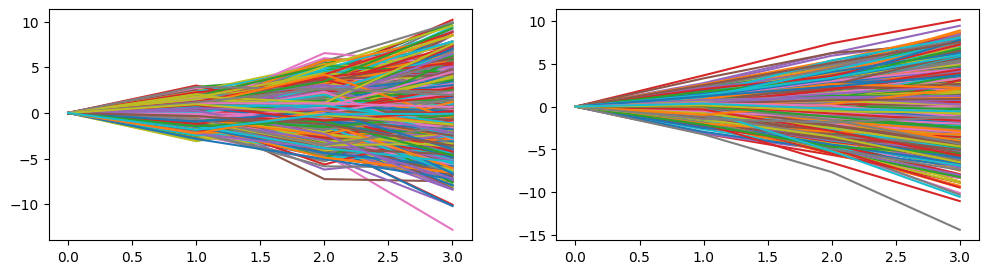

In [47]:
# Grid projection of k-mean projection
def adapted_empirical_measure(samples, delta_n):
    grid_func = lambda x: np.floor(x / delta_n + 0.5) * delta_n
    adapted_samples = grid_func(samples)
    return adapted_samples


adaptedX = adapted_empirical_measure(X, delta_n=0.05)
adaptedY = adapted_empirical_measure(Y, delta_n=0.05)

fig, ax = plt.subplots(1, 2, figsize=[12, 3])
ax[0].plot(adaptedX)
ax[1].plot(adaptedY)
plt.show()

In [48]:
# Quantization
# Here I use the biggest one which works for both X and Y samples grid for simplicity.
q2v_list = np.unique(np.concatenate([adaptedX, adaptedY], axis=0))
v2q_dict = {k: v for v, k in enumerate(q2v_list)}
# q2v_list, v2q_dict
len(q2v_list)

340

In [50]:
adapted_newX = np.column_stack((adaptedX[0], adaptedX[1], adaptedX[2], adaptedX[3]))
adapted_newY = np.column_stack((adaptedY[0], adaptedY[1], adaptedY[2], adaptedY[3]))

new_sample_pathsA, new_weightsA = empirical_grid_measure(adapted_newX, use_weights=True)
new_sample_pathsB, new_weightsB = empirical_grid_measure(adapted_newY, use_weights=True)

tree1 = build_tree_from_paths(new_sample_pathsA, new_weightsA)
tree2 = build_tree_from_paths(new_sample_pathsB, new_weightsB)

max_depth_tree = get_depth(tree2)
start_time_tree = time()
distance_tree = compute_nested_distance(
    tree1,
    tree2,
    max_depth_tree,
    method="solver_lp_pot",
    return_matrix=False,
    lambda_reg=0,
    power=2,
)
elapsed_time_tree = time() - start_time_tree

print(distance_tree)

10.396278025317038


In [ ]:
from collections import defaultdict

T = 3


def path2cm(adaptedpath):
    r"""
    Path to Conditional Measure
    """
    mu_x = [defaultdict(dict) for t in range(T - 1)]
    for path in adaptedpath.T:
        for t in range(T - 1):
            pre_path = tuple(v2q_dict[v] for v in path[: t + 1])
            next_val = v2q_dict[path[t + 1]]
            if pre_path not in mu_x[t] or next_val not in mu_x[t][pre_path]:
                mu_x[t][pre_path][next_val] = 1
            else:
                mu_x[t][pre_path][next_val] += 1
    return mu_x


mu_x = path2cm(adaptedX)
nu_y = path2cm(adaptedY)

In [52]:
# --- Added Code ---
def display_adapted_measure(mu, label="Adapted Measure"):
    """
    Display the adapted measure as a list of sample paths with associated weights.
    For each time stage, it prints the pre-path, the continuation step, and the normalized weight.
    """
    print(f"\n{label}:")
    for t, mu_t in enumerate(mu):
        print(f"\nTime stage t = {t+1}:")
        for pre_path, next_dict in mu_t.items():
            total = sum(next_dict.values())
            for next_val, count in next_dict.items():
                weight = count / total
                # The full path at this stage is the pre_path plus the next value
                full_path = pre_path + (next_val,)
                # Optionally, you can also recover the actual quantized value using q2v_list
                quantized_path = tuple(q2v_list[i] for i in full_path)
                print(
                    f"  Sample path indices: {full_path}, Quantized values: {quantized_path}, Weight: {weight:.4f}"
                )


# Display the adapted empirical measures for X and Y
display_adapted_measure(mu_x, label="Adapted Measure for X")
display_adapted_measure(nu_y, label="Adapted Measure for Y")
# --- End of Added Code ---


Adapted Measure for X:

Time stage t = 1:
  Sample path indices: (168, 142), Quantized values: (0.0, -1.3), Weight: 0.0070
  Sample path indices: (168, 155), Quantized values: (0.0, -0.65), Weight: 0.0190
  Sample path indices: (168, 161), Quantized values: (0.0, -0.35000000000000003), Weight: 0.0160
  Sample path indices: (168, 141), Quantized values: (0.0, -1.35), Weight: 0.0100
  Sample path indices: (168, 188), Quantized values: (0.0, 1.0), Weight: 0.0110
  Sample path indices: (168, 163), Quantized values: (0.0, -0.25), Weight: 0.0210
  Sample path indices: (168, 207), Quantized values: (0.0, 1.9500000000000002), Weight: 0.0040
  Sample path indices: (168, 169), Quantized values: (0.0, 0.05), Weight: 0.0260
  Sample path indices: (168, 144), Quantized values: (0.0, -1.2000000000000002), Weight: 0.0140
  Sample path indices: (168, 151), Quantized values: (0.0, -0.8500000000000001), Weight: 0.0160
  Sample path indices: (168, 160), Quantized values: (0.0, -0.4), Weight: 0.0230
  Sa

In [53]:
def get_adapted_measure_as_list(mu, q2v_list):
    """
    Given an adapted measure 'mu' (a list of dictionaries from path2cm) and the list
    of quantized values q2v_list, returns a list (one element per time stage) where
    each element is a list of dictionaries containing:
      - 'time_stage': the time stage (starting at 1),
      - 'sample_path_indices': the tuple of indices (pre-path concatenated with next value),
      - 'sample_path_values': the tuple of actual quantized values,
      - 'weight': the normalized weight (count divided by the total count for that pre-path)
    """
    adapted_list = []
    for t, measure in enumerate(mu):
        stage_samples = []
        for pre_path, next_steps in measure.items():
            total = sum(next_steps.values())
            for next_val, count in next_steps.items():
                full_path = pre_path + (next_val,)
                weight = count / total
                quantized_path = tuple(q2v_list[i] for i in full_path)
                stage_samples.append(
                    {
                        "time_stage": t + 1,
                        "sample_path_indices": full_path,
                        "sample_path_values": quantized_path,
                        "weight": weight,
                    }
                )
        adapted_list.append(stage_samples)
    return adapted_list


# Now extract for mu_x and nu_y:
adapted_mu_list = get_adapted_measure_as_list(mu_x, q2v_list)
adapted_nu_list = get_adapted_measure_as_list(nu_y, q2v_list)

In [54]:
import numpy as np


def extract_paths_and_weights(adapted_list):
    paths = []
    weights = []
    for stage in adapted_list:
        for entry in stage:
            paths.append(entry["sample_path_values"])
            weights.append(entry["weight"])
    # Use dtype=object if the sample paths have different lengths.
    return np.array(paths, dtype=object), np.array(weights)


mu_paths, mu_weights = extract_paths_and_weights(adapted_mu_list)
nu_paths, nu_weights = extract_paths_and_weights(adapted_nu_list)

print("Adapted mu paths:")
print(mu_paths)
print("Adapted mu weights:")
print(mu_weights)

print("Adapted nu paths:")
print(nu_paths)
print("Adapted nu weights:")
print(nu_weights)

Adapted mu paths:
[(0.0, -1.3) (0.0, -0.65) (0.0, -0.35000000000000003) ...
 (0.0, 1.1500000000000001, 2.7, 1.9500000000000002)
 (0.0, 0.9500000000000001, -0.25, -1.25)
 (0.0, -1.85, -0.15000000000000002, -0.1)]
Adapted mu weights:
[0.007 0.019 0.016 ... 1.    1.    1.   ]
Adapted nu paths:
[(0.0, -0.9) (0.0, 0.2) (0.0, -1.9000000000000001) ...
 (0.0, 0.4, 0.1, -1.1500000000000001)
 (0.0, -1.4500000000000002, -1.85, -1.2000000000000002)
 (0.0, 0.35000000000000003, -0.25, -0.55)]
Adapted nu weights:
[0.015 0.016 0.005 ... 1.    1.    1.   ]


In [55]:
import numpy as np

# First, separate the extracted paths by length:
mu_paths_len2 = [list(p) for p, w in zip(mu_paths, mu_weights) if len(p) == 2]
mu_weights_len2 = [w for p, w in zip(mu_paths, mu_weights) if len(p) == 2]

mu_paths_len3_raw = [list(p) for p, w in zip(mu_paths, mu_weights) if len(p) == 3]
mu_weights_len3_raw = [w for p, w in zip(mu_paths, mu_weights) if len(p) == 3]

# Build a dictionary for the parent (length 2) paths for mu.
# We assume that each unique parent appears only once.
mu_parent_dict = {tuple(p): w for p, w in zip(mu_paths, mu_weights) if len(p) == 2}

# Now, for each mu path of length 3, get its parent weight and multiply:
mu_paths_len3 = []
mu_weights_len3 = []
for p, w in zip(mu_paths, mu_weights):
    if len(p) == 3:
        parent = tuple(p[:2])
        if parent in mu_parent_dict:
            full_weight = mu_parent_dict[parent] * w
            mu_paths_len3.append(list(p))  # convert to list (if not already)
            mu_weights_len3.append(full_weight)
        else:
            print("Warning: no parent found for path", p)

# Do the same for nu.
nu_paths_len2 = [list(p) for p, w in zip(nu_paths, nu_weights) if len(p) == 2]
nu_weights_len2 = [w for p, w in zip(nu_paths, nu_weights) if len(p) == 2]

nu_parent_dict = {tuple(p): w for p, w in zip(nu_paths, nu_weights) if len(p) == 2}

nu_paths_len3 = []
nu_weights_len3 = []
for p, w in zip(nu_paths, nu_weights):
    if len(p) == 3:
        parent = tuple(p[:2])
        if parent in nu_parent_dict:
            full_weight = nu_parent_dict[parent] * w
            nu_paths_len3.append(list(p))
            nu_weights_len3.append(full_weight)
        else:
            print("Warning: no parent found for path", p)

# Now print the results as lists:
print("Adapted mu paths of length 3 (as lists):")
print(mu_paths_len3)
print("Adapted mu weights of length 3:")
print(mu_weights_len3)

print("Adapted nu paths of length 3 (as lists):")
print(nu_paths_len3)
print("Adapted nu weights of length 3:")
print(nu_weights_len3)


def check_duplicates(lst):
    unique_lists = set(tuple(sublist) for sublist in lst)
    return len(unique_lists) != len(lst)

Adapted mu paths of length 3 (as lists):
[[0.0, -1.3, -1.3], [0.0, -1.3, -1.1500000000000001], [0.0, -1.3, -4.15], [0.0, -1.3, 2.2], [0.0, -1.3, -2.6500000000000004], [0.0, -1.3, -0.55], [0.0, -1.3, -0.5], [0.0, -0.65, -0.8], [0.0, -0.65, -1.1], [0.0, -0.65, -0.5], [0.0, -0.65, 2.45], [0.0, -0.65, -3.95], [0.0, -0.65, 4.65], [0.0, -0.65, -1.1500000000000001], [0.0, -0.65, -0.25], [0.0, -0.65, 0.25], [0.0, -0.65, -0.35000000000000003], [0.0, -0.65, 1.6500000000000001], [0.0, -0.65, -0.65], [0.0, -0.65, -0.6000000000000001], [0.0, -0.65, 1.3], [0.0, -0.65, -4.65], [0.0, -0.65, -1.05], [0.0, -0.65, -1.55], [0.0, -0.65, 0.6000000000000001], [0.0, -0.65, -3.5500000000000003], [0.0, -0.35000000000000003, 5.45], [0.0, -0.35000000000000003, -0.15000000000000002], [0.0, -0.35000000000000003, -1.4500000000000002], [0.0, -0.35000000000000003, -4.7], [0.0, -0.35000000000000003, -2.5], [0.0, -0.35000000000000003, -2.3000000000000003], [0.0, -0.35000000000000003, -2.35], [0.0, -0.35000000000000003, 

In [57]:
tree1 = build_tree_from_paths(mu_paths_len3, mu_weights_len3)
tree2 = build_tree_from_paths(nu_paths_len3, nu_weights_len3)

max_depth_tree = get_depth(tree2)
start_time_tree = time()
distance_tree = compute_nested_distance(
    tree1,
    tree2,
    max_depth_tree,
    method="solver_lp_pot",
    return_matrix=False,
    lambda_reg=0,
    power=2,
)
elapsed_time_tree = time() - start_time_tree

print(distance_tree)

2.2109809652144556


In [58]:
# Step t = 2
import ot

square_cost_matrix = (q2v_list[None, :] - q2v_list[None, :].T) ** 2
V1 = {}
for k1, v1 in mu_x[1].items():
    for k2, v2 in nu_y[1].items():
        w1 = list(v1.values())
        w1 = np.array(w1) / sum(w1)

        w2 = list(v2.values())
        w2 = np.array(w2) / sum(w2)

        square_cost = square_cost_matrix[np.ix_(list(v1.keys()), list(v2.keys()))]
        dist_W2square = ot.emd2(w1, w2, square_cost)

        V1[(k1, k2)] = dist_W2square

In [59]:
# Step t = 1
V0 = {}
for k1, v1 in mu_x[0].items():
    for k2, v2 in nu_y[0].items():
        w1 = list(v1.values())
        w1 = np.array(w1) / sum(w1)

        w2 = list(v2.values())
        w2 = np.array(w2) / sum(w2)

        q1s = list(v1.keys())
        q2s = list(v2.keys())

        square_cost = square_cost_matrix[np.ix_(q1s, q2s)]
        for i, q1 in enumerate(q1s):
            for j, q2 in enumerate(q2s):
                q_pair = (k1 + (q1,), k2 + (q2,))
                square_cost[i, j] += V1[q_pair]

        dist_W2square = ot.emd2(w1, w2, square_cost)
        V0[(k1, k2)] = dist_W2square
AW_2square = list(V0.values())[0]

In [60]:
def adapted_wasserstein_squared(a, A, b, B):
    # Cholesky decompositions: A = L L^T, B = M M^T
    L = np.linalg.cholesky(A)
    M = np.linalg.cholesky(B)
    # Mean squared difference
    mean_diff = np.sum((a - b) ** 2)
    # Trace terms
    trace_sum = np.trace(A) + np.trace(B)
    # L1 norm of diagonal elements of L^T M
    l1_diag = np.sum(np.abs(np.diag(L.T @ M)))
    # Final adapted Wasserstein squared distance
    return mean_diff + trace_sum - 2 * l1_diag


a, b = np.zeros([3]), np.zeros([3])
dist_bench = adapted_wasserstein_squared(a, A, b, B)
print("Theoretical AW_2^2: ", dist_bench)
print("Numerical AW_2^2: ", AW_2square)

Theoretical AW_2^2:  10.0
Numerical AW_2^2:  2.2109809652144605
